In [1]:
import os
import math

from typing import List, Tuple, Callable, Optional

import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns

from torch.utils.data import DataLoader
from catalyst import dl
from catalyst.dl import SupervisedRunner, Runner
from catalyst.contrib.nn.optimizers import RAdam, Lookahead, Adam
from catalyst.dl.callbacks import OptimizerCallback, EarlyStoppingCallback, SchedulerCallback, CriterionCallback, MetricAggregationCallback, CheckpointCallback
from catalyst.dl import Callback, CallbackOrder
from catalyst.dl import utils
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from matplotlib import pyplot as plt

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

## Reproducibility

In [2]:
RS = 42
DEVICE = 'cuda'

In [3]:
utils.set_global_seed(RS)
utils.prepare_cudnn(deterministic=True)

if DEVICE == 'cuda':
    os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Neural Net 

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class MultiEmbedding(torch.nn.Module):
    def __init__(
        self, 
        embedding_sizes_list: List[Tuple[int,int]]
    ):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(size[0],size[1]) for size in embedding_sizes_list
        ])

    def forward(self, x):
        x = torch.cat([
            self.embeddings[i](x[:,i]) for i in range(x.shape[1])
        ], axis=-1)
        return x
    
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

    
ACT_DICT = {
    "RELU":nn.ReLU,
    "ELU":nn.ELU,
    "MISH":Mish,
    "SWISH":Swish,
    "SIGMOID":nn.Sigmoid,
    "IDENTITY":nn.Identity,
}
    
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(
        self, 
        embedding_sizes_list: List[Tuple[int,int]],
        n_cont_features: int,
        linear_config_list: List[Tuple[int, float, str]]
    ):
        super().__init__()
        self.embeddings = MultiEmbedding(embedding_sizes_list)
        input_size = sum(el[1] for el in embedding_sizes_list) + n_cont_features
        
        self.linears = nn.ModuleList()
        for idx, conf in enumerate(linear_config_list):
            output_size, dropout_rate, activation_type = conf
            if idx != len(linear_config_list) - 1: 
                self.linears.append(nn.Sequential(
                    nn.Conv1d(input_size, output_size, kernel_size=1),
                    nn.BatchNorm1d(output_size),
                    ACT_DICT[activation_type](),
                    nn.Dropout(dropout_rate)
                ))
            else:
                self.linears.append(nn.Sequential(
                    nn.Conv1d(input_size, output_size, kernel_size=1),
                ))
            input_size = output_size
       
    def forward(self, x_ordinal, x_categorical):
        x_categorical = self.embeddings(x_categorical)
        x = torch.cat([x_categorical, x_ordinal], axis=-1)
        
        x = x.unsqueeze(-1)
        
        for linear in self.linears:
            x = linear(x)
            
        x = x.squeeze(-1)
            
        return x

## Catalyst utils

In [5]:
class CustomRunner(dl.Runner):

    def _handle_batch(self, batch):

        losses, inputs, outputs = self.criterion(
            batch,
            self.model
        )

        self.batch_metrics.update(losses)
        self.input = inputs
        self.output = outputs
        
    def predict_batch(self, batch):
        batch = self._batch2device(batch, self.device)
        x_ordinal, x_categorical, target = batch
        logits = model(x_ordinal, x_categorical)
        return logits.detach().cpu().numpy()


In [6]:
class SklearnMetricCallback(Callback):
    def __init__(
        self,
        metric_function: Callable,
        metric_name: str,
        metric_thresh: Optional[float] = None
    ):
        super().__init__(CallbackOrder.Metric)
        self.metric_function = metric_function
        self.metric_name = metric_name
        self.metric_thresh = metric_thresh
        
        self.running_preds = []
        self.running_targets = []
        
    def on_batch_end(self, state):
        y_hat = state.output['logits'].detach().cpu().numpy()
        y = state.input['targets'].detach().cpu().numpy()

        self.running_preds.append(y_hat)
        self.running_targets.append(y)
            
    def on_loader_end(self, state):
        y_true = np.concatenate(self.running_targets)
        y_pred = np.concatenate(self.running_preds)
        
        if self.metric_thresh is not None:
            y_pred = (y_pred > self.metric_thresh).astype(int)
        
        state.loader_metrics[self.metric_name] = self.metric_function(y_true, y_pred)

        self.running_preds = []
        self.running_targets = [] 


In [7]:
class BCELoss(nn.Module):

    def __init__(self):
        super().__init__()
        self.loss_f = nn.BCEWithLogitsLoss()

    def forward(self, batch, model):

        x_ordinal, x_categorical, target = batch
        logits = model(x_ordinal, x_categorical)
        loss = self.loss_f(logits, target)

        return {"loss":loss}, {"targets":target[:,0]}, {"logits":logits[:,0]}


## Read data

In [8]:
df = pd.read_csv('../data/heart.csv')
folds = np.load('../data/5folds_bytarget.npy', allow_pickle=True)

In [9]:
ordinal_features = [
 'age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal'   
]
target_feature = ['target']
bool_features = [
    'sex', 'exang', 'fbs'
]
categorical_features = [
    'cp', 'restecg', 'slope'
]

## Normalize Ordinal

In [10]:
for col in ordinal_features:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

## Training Loop

In [11]:
#!rm -rf ../logdirs/baseline_3layers

In [12]:
EXP_NAME = 'baseline_3layers'
batch_size = 16

df['predicted_logits'] = 0
df['fold_n'] = 0

if os.path.exists(f'../logdirs/{EXP_NAME}'):
    raise ValueError('log directory exist')

for i, (train_idx, val_idx) in enumerate(folds):
    
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    
    dataset_train = torch.utils.data.TensorDataset(
        torch.Tensor(np.array(train_df[ordinal_features])),
        torch.LongTensor(np.array(train_df[categorical_features + bool_features])),
        torch.Tensor(np.array(train_df[target_feature]))
    )
    dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True, drop_last=True)

    dataset_val = torch.utils.data.TensorDataset(
        torch.Tensor(np.array(val_df[ordinal_features])),
        torch.LongTensor(np.array(val_df[categorical_features + bool_features])),
        torch.Tensor(np.array(val_df[target_feature]))
    )
    dataloader_val = DataLoader(dataset_val, batch_size)

    loaders = {'train':dataloader_train, 'valid': dataloader_val}

    model = MultiLayerPerceptron(
        embedding_sizes_list=[(4,8),(3,6),(3,6),(2,4),(2,4),(2,4)],
        n_cont_features=len(ordinal_features),
        linear_config_list=[
            #(64, 0.2, "MISH"),
            (128, 0.2, "MISH"),
            (64, 0.2, "MISH"),
            (1, 0.0, "IDENTITY")
        ]
    )
    print(model)

    optimizer = Lookahead(RAdam(model.parameters(), lr=1e-3))

    criterion =  BCELoss()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, mode='max')

    callbacks =[
                SklearnMetricCallback(accuracy_score, 'accuracy', 0.0),
                SklearnMetricCallback(roc_auc_score, 'roc_auc'),
                OptimizerCallback(metric_key="loss", accumulation_steps=1),
                EarlyStoppingCallback(patience=10, metric='roc_auc', minimize=False),
                SchedulerCallback(mode='epoch', reduced_metric="roc_auc"),
            ]

    runner = CustomRunner()

    runner.train(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            loaders=loaders,
            logdir=f'../logdirs/{EXP_NAME}/fold_{i}',
            num_epochs=9999,
            verbose=True,
            load_best_on_end=True,
            main_metric="roc_auc",
            minimize_metric=False,
            callbacks=callbacks
        )    
    
    model_path = f'../logdirs/{EXP_NAME}/fold_{i}/checkpoints/best_full.pth'
    prediction = runner.predict_loader(
        loader=dataloader_val, 
        model=MultiLayerPerceptron(
            embedding_sizes_list=[(4,8),(3,6),(3,6),(2,4),(2,4),(2,4)],
            n_cont_features=len(ordinal_features),
            linear_config_list=[
                #(64, 0.2, "MISH"),
                (128, 0.2, "MISH"),
                (64, 0.2, "MISH"),
                (1, 0.0, "IDENTITY")
            ]
        ), 
        resume=model_path
    )
    df.iloc[val_idx, -2] = np.concatenate(list(prediction))[:,0]
    df.iloc[val_idx, -1] = i

MultiLayerPerceptron(
  (embeddings): MultiEmbedding(
    (embeddings): ModuleList(
      (0): Embedding(4, 8)
      (1): Embedding(3, 6)
      (2): Embedding(3, 6)
      (3): Embedding(2, 4)
      (4): Embedding(2, 4)
      (5): Embedding(2, 4)
    )
  )
  (linears): ModuleList(
    (0): Sequential(
      (0): Conv1d(39, 128, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
      (3): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
    )
  )
)
1/9999 * Epoch (train): 100% 14/14 [00:01<00:00,  7.90it/s, loss=0.690]
1/9999 * Epoch (valid): 100% 4/4 [00:00<00:00, 168.09it/s, loss=0.702]
[2020-09-29 09:0

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)



2/9999 * Epoch (train): 100% 14/14 [00:00<00:00, 107.90it/s, loss=0.726]
2/9999 * Epoch (valid): 100% 4/4 [00:00<00:00, 208.03it/s, loss=0.647]
[2020-09-29 09:04:06,154] 
2/9999 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/9999 * Epoch 2 (train): accuracy=0.4777 | loss=0.7180 | roc_auc=0.5052
2/9999 * Epoch 2 (valid): accuracy=0.5833 | loss=0.6810 | roc_auc=0.6184
3/9999 * Epoch (train): 100% 14/14 [00:00<00:00, 108.69it/s, loss=0.732]
3/9999 * Epoch (valid): 100% 4/4 [00:00<00:00, 210.77it/s, loss=0.608]
[2020-09-29 09:04:06,311] 
3/9999 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/9999 * Epoch 3 (train): accuracy=0.5893 | loss=0.6645 | roc_auc=0.6494
3/9999 * Epoch 3 (valid): accuracy=0.6667 | loss=0.6552 | roc_auc=0.7059
4/9999 * Epoch (train): 100% 14/14 [00:00<00:00, 112.01it/s, loss=0.726]
4/9999 * Epoch (valid): 100% 4/4 [00:00<00:00, 223.84it/s, loss=0.592]
[2020-09-29 09:04:06,464] 
4/9999 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/9999 * Epoch 4 (train): accurac

## Analyze results

In [13]:
def compute_metrics(
    result_df: pd.DataFrame,
    metric_list: List[Tuple[str,Callable, Optional[float]]]
):
    for metric_name, metric_function, threshold in metric_list:
        if threshold is not None:
            pred = (result_df['predicted_logits'] > threshold).astype(int)
        else:
            pred = result_df['predicted_logits']
            
        oof_metric = metric_function(
            result_df['target'], 
            pred
        )
        
        if threshold is not None:
            fold_scores = df.groupby('fold_n').apply(lambda x: metric_function(
                x['target'], 
                (x['predicted_logits'] > threshold).astype(int)
            ))
        else:
            fold_scores = df.groupby('fold_n').apply(lambda x: metric_function(
                x['target'], 
                x['predicted_logits']
            ))
        
        print(metric_name)
        print(f'OOF : {oof_metric}')
        print(f'Fold scores: {fold_scores}')
        print(f'Fold mean: {fold_scores.mean()}')
        print(f'Fold std: {fold_scores.std()}')
        print('\n\n')

In [14]:
compute_metrics(
    df,
    metric_list=[
        ('roc_auc', roc_auc_score, None),
        ('accuracy', accuracy_score, 0.0)
    ]
)

roc_auc
OOF : 0.9102423411065387
Fold scores: fold_n
0    0.956229
1    0.941639
2    0.938657
3    0.821759
4    0.890046
dtype: float64
Fold mean: 0.9096661054994388
Fold std: 0.05509851658418262



accuracy
OOF : 0.8181818181818182
Fold scores: fold_n
0    0.850000
1    0.900000
2    0.847458
3    0.694915
4    0.796610
dtype: float64
Fold mean: 0.8177966101694916
Fold std: 0.0778185781915186





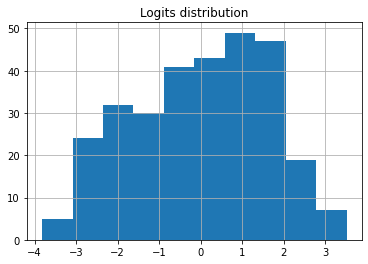

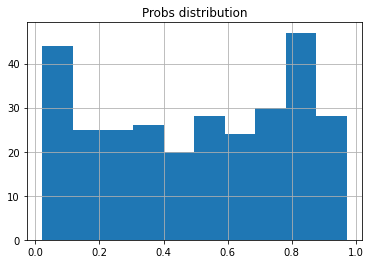

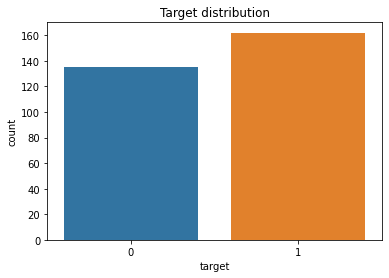

In [15]:
plt.title('Logits distribution')
df['predicted_logits'].hist()
plt.show()

plt.title('Probs distribution')
sigmoid(df['predicted_logits']).hist()
plt.show()

plt.title('Target distribution')
sns.countplot(df['target'])
plt.show()

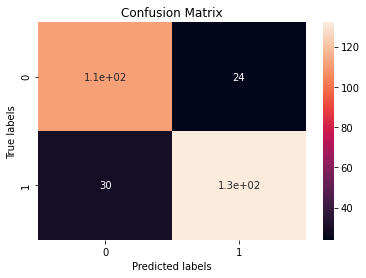

In [16]:
cm = confusion_matrix(
    df['target'], 
    (df['predicted_logits'] > 0.0).astype(int)
)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

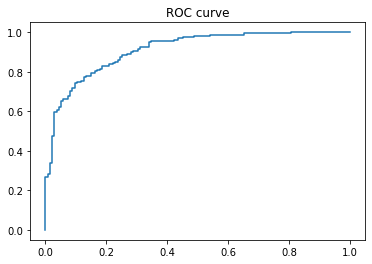

In [17]:
fpr, tpr, _ = roc_curve(df['target'], df['predicted_logits'])

plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.show()

## Thanks for reading!!!